# Evaluate generalizability of the model across holdout plate(s)

## Import libraries

In [1]:
import pandas as pd
import pathlib
from joblib import load
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_recall_curve,
)
import seaborn as sns
import matplotlib.pyplot as plt

## Set paths and variables

In [2]:
# Set data type for the generalizability evaluation
data_cleaned = "cleaned"

# Set suffix for data files if using QC or cleaned data
if data_cleaned == "cleaned":
    suffix = "_qc"
else:
    suffix = ""

# Path to folder holding model and encoder files
model_dir = pathlib.Path("../1.train_models/data")

# Load in the model encoder
le = load(pathlib.Path(f"{model_dir}/trained_nf1_model_label_encoder{suffix}.joblib"))

# Load in the model
model = load(pathlib.Path(f"{model_dir}/trained_nf1_model{suffix}.joblib"))

# Path to results directory
results_dir = pathlib.Path("./results")
results_dir.mkdir(exist_ok=True)

# Set the random seed
rng = np.random.default_rng(0)

## Load in plate with two cell lines (Plate 6)

In [3]:
# Set directory to find the plate 6 data from based on data type
directory = (
    "single_cell_profiles/cleaned_sc_profiles"
    if data_cleaned == "cleaned"
    else "single_cell_profiles"
)

# Read in data from plate 6 with two cell lines
plate6_df = pd.read_parquet(
    pathlib.Path(
        f"/media/18tbdrive/1.Github_Repositories/nf1_schwann_cell_painting_data/3.processing_features/data/{directory}/Plate_6_sc_normalized.parquet"
    )
)

# Count rows before dropping NaNs
initial_count = plate6_df.shape[0]

# Drop rows with NaNs
plate6_df = plate6_df.dropna()

# Count rows after dropping NaNs
final_count = plate6_df.shape[0]

# Print the count of dropped rows
print(f"Dropped rows: {initial_count - final_count}")

# Print shape and head of data
print(plate6_df.shape)
plate6_df.head()

Dropped rows: 157
(6643, 2323)


,Metadata_WellRow,Metadata_WellCol,Metadata_Well,Metadata_Site,Metadata_number_of_singlecells,Metadata_gene_name,Metadata_genotype,Metadata_Institution,Metadata_seed_density,Metadata_ImageNumber,...,Nuclei_Texture_Variance_DAPI_3_02_256,Nuclei_Texture_Variance_DAPI_3_03_256,Nuclei_Texture_Variance_GFP_3_00_256,Nuclei_Texture_Variance_GFP_3_01_256,Nuclei_Texture_Variance_GFP_3_02_256,Nuclei_Texture_Variance_GFP_3_03_256,Nuclei_Texture_Variance_RFP_3_00_256,Nuclei_Texture_Variance_RFP_3_01_256,Nuclei_Texture_Variance_RFP_3_02_256,Nuclei_Texture_Variance_RFP_3_03_256
0,B,2,B2,2,129,NF1,WT,iNFixion,1000,88,...,0.108655,0.163279,0.185683,0.205478,0.210506,0.210866,0.153883,0.198561,0.182786,0.166771
2,B,2,B2,10,129,NF1,WT,iNFixion,1000,67,...,1.046295,1.098029,-0.449910,-0.451553,-0.404167,-0.344521,0.079283,0.058022,0.094928,0.084114
3,B,2,B2,13,129,NF1,WT,iNFixion,1000,70,...,0.555761,0.533358,-0.640786,-0.617863,-0.625237,-0.631399,-0.317819,-0.337793,-0.341007,-0.321586
4,B,2,B2,17,129,NF1,WT,iNFixion,1000,74,...,1.360053,1.301593,1.706935,1.651384,1.744802,1.791042,-0.293071,-0.310315,-0.273867,-0.278295
5,B,2,B2,18,129,NF1,WT,iNFixion,1000,75,...,0.276145,0.107734,1.093270,1.236344,1.544765,1.117287,0.807448,0.947946,1.036270,0.764962


## Generate a shuffled dataset from the loaded in plate

In [4]:
# Shuffle the features randomly, excluding columns that start with "Metadata_"
shuffled_plate6_df = plate6_df.apply(
    lambda x: rng.permutation(x) if not x.name.startswith("Metadata_") else x
)

# Print shape and head of data
print(shuffled_plate6_df.shape)
shuffled_plate6_df.head()

(6643, 2323)


,Metadata_WellRow,Metadata_WellCol,Metadata_Well,Metadata_Site,Metadata_number_of_singlecells,Metadata_gene_name,Metadata_genotype,Metadata_Institution,Metadata_seed_density,Metadata_ImageNumber,...,Nuclei_Texture_Variance_DAPI_3_02_256,Nuclei_Texture_Variance_DAPI_3_03_256,Nuclei_Texture_Variance_GFP_3_00_256,Nuclei_Texture_Variance_GFP_3_01_256,Nuclei_Texture_Variance_GFP_3_02_256,Nuclei_Texture_Variance_GFP_3_03_256,Nuclei_Texture_Variance_RFP_3_00_256,Nuclei_Texture_Variance_RFP_3_01_256,Nuclei_Texture_Variance_RFP_3_02_256,Nuclei_Texture_Variance_RFP_3_03_256
0,B,2,B2,2,129,NF1,WT,iNFixion,1000,88,...,-0.916135,0.371356,1.447822,-0.383230,-0.548891,1.425081,-0.237073,-0.946357,-0.911325,1.150063
2,B,2,B2,10,129,NF1,WT,iNFixion,1000,67,...,-0.660806,-0.956766,-0.823986,-0.406127,-0.512657,1.053579,0.795152,-0.813955,-0.358445,-0.478181
3,B,2,B2,13,129,NF1,WT,iNFixion,1000,70,...,-0.698661,-1.202202,0.766777,0.350558,-0.826542,-0.391425,-0.984931,-0.855646,-0.311206,-0.273983
4,B,2,B2,17,129,NF1,WT,iNFixion,1000,74,...,-0.957770,1.264268,-0.380203,-0.653960,-0.530561,-0.697384,-0.669847,-0.680256,-0.223085,-0.559199
5,B,2,B2,18,129,NF1,WT,iNFixion,1000,75,...,-1.147947,-1.434918,-0.596931,-0.117699,-0.496899,-0.606697,-1.027366,2.073648,-0.651842,-0.962872


## Apply model to final and shuffled versions of the plate data

In [5]:
# Create list of the metadata columns only
meta_cols = [col for col in plate6_df.columns if "Metadata" in col]

# Define a dictionary to handle both data types
data_dict = {"final": plate6_df, "shuffled": shuffled_plate6_df}

# Initialize a list to store processed dataframes
processed_dfs = []

# Loop through the data dictionary to create probability dataframes
for data_type, data in data_dict.items():
    # Ensure no duplicates in data and reset index
    data = data.drop_duplicates().reset_index(drop=True)

    # Predict probabilities and labels
    probabilities = model.predict_proba(data[model.feature_names_in_])[:, 1]
    predicted_genotype = model.predict(
        data[model.feature_names_in_]
    )  # outputs as binary labels

    # Make a copy of the column to avoid modifying the original dataframe
    true_genotype = data["Metadata_genotype"].copy()

    # Set HET values to 2 explicitly
    true_genotype.loc[true_genotype == "HET"] = 2

    # Use label encoder for the remaining values (excluding HET)
    mask = true_genotype != 2  # Identify rows that are not HET
    true_genotype.loc[mask] = le.transform(true_genotype.loc[mask])

    # Convert dtype to integer
    true_genotype = true_genotype.astype(int)

    # Create a dataframe with probabilities and predictions
    probability_df = pd.DataFrame(
        {
            "probability_WT": probabilities,
            "predicted_genotype": predicted_genotype,
            "true_genotype": true_genotype,
            "data_type": data_type,
        },
        index=data.index,  # Ensure alignment with original data
    )

    # Add metadata columns (reset index to align lengths)
    metadata_df = data[meta_cols].reset_index(drop=True)
    assert len(probability_df) == len(
        metadata_df
    ), "Row count mismatch between probabilities and metadata!"

    full_df = pd.concat([probability_df, metadata_df], axis=1)
    processed_dfs.append(full_df)

# Combine all dataframes
combined_df = pd.concat(processed_dfs, axis=0).reset_index(drop=True)

# Save to Parquet with qc suffix if data is cleaned
if data_cleaned == "cleaned":
    output_file = (
        pathlib.Path(results_dir) / "plate_6_single_cell_probabilities_qc.parquet"
    )
else:
    output_file = (
        pathlib.Path(results_dir) / "plate_6_single_cell_probabilities.parquet"
    )

combined_df.to_parquet(output_file)

# Print shape and head of data
print(combined_df.shape)
combined_df.head()

(13286, 27)


,probability_WT,predicted_genotype,true_genotype,data_type,Metadata_WellRow,Metadata_WellCol,Metadata_Well,Metadata_Site,Metadata_number_of_singlecells,Metadata_gene_name,...,Metadata_Cytoplasm_Parent_Nuclei,Metadata_Nuclei_Number_Object_Number,Metadata_Image_FileName_CY5,Metadata_Image_FileName_DAPI,Metadata_Image_FileName_GFP,Metadata_Image_FileName_RFP,Metadata_Cells_Location_Center_X,Metadata_Cells_Location_Center_Y,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y
0,0.258875,0,1,final,B,2,B2,2,129,NF1,...,1,1,B2_01_3_2_CY5_001_illumcorrect.tiff,B2_01_1_2_DAPI_001_illumcorrect.tiff,B2_01_2_2_GFP_001_illumcorrect.tiff,B2_01_4_2_RFP_001_illumcorrect.tiff,416.103047,206.097181,440.012394,201.108451
1,0.400323,0,1,final,B,2,B2,10,129,NF1,...,2,2,B2_01_3_10_CY5_001_illumcorrect.tiff,B2_01_1_10_DAPI_001_illumcorrect.tiff,B2_01_2_10_GFP_001_illumcorrect.tiff,B2_01_4_10_RFP_001_illumcorrect.tiff,281.689228,161.139974,330.517905,161.275254
2,0.163147,0,1,final,B,2,B2,13,129,NF1,...,2,2,B2_01_3_13_CY5_001_illumcorrect.tiff,B2_01_1_13_DAPI_001_illumcorrect.tiff,B2_01_2_13_GFP_001_illumcorrect.tiff,B2_01_4_13_RFP_001_illumcorrect.tiff,629.209868,398.548843,596.214286,375.611395
3,0.971260,1,1,final,B,2,B2,17,129,NF1,...,2,2,B2_01_3_17_CY5_001_illumcorrect.tiff,B2_01_1_17_DAPI_001_illumcorrect.tiff,B2_01_2_17_GFP_001_illumcorrect.tiff,B2_01_4_17_RFP_001_illumcorrect.tiff,640.892875,333.458652,641.043451,364.167598
4,0.991034,1,1,final,B,2,B2,18,129,NF1,...,2,2,B2_01_3_18_CY5_001_illumcorrect.tiff,B2_01_1_18_DAPI_001_illumcorrect.tiff,B2_01_2_18_GFP_001_illumcorrect.tiff,B2_01_4_18_RFP_001_illumcorrect.tiff,100.930065,497.509751,79.371992,510.599599


## Split the probability data by Institution

In [6]:
# Create dictionary with the split dataframes based on Institution
institution_dfs = {
    institution: combined_df[combined_df["Metadata_Institution"] == institution].copy()
    for institution in combined_df["Metadata_Institution"].unique()
}

## Generate PR curve results (for pre-visualization)

In [7]:
precision_recall_data = []

for institution, df in institution_dfs.items():
    for data_type in ["final", "shuffled"]:  # Compute separately for both types
        # Subset for data type and remove the HET cells from evaluation
        subset_df = df[
            (df["data_type"] == data_type) & (df["Metadata_genotype"] != "HET")
        ]

        # Compute precision-recall curve
        precision, recall, _ = precision_recall_curve(
            subset_df["true_genotype"], subset_df["probability_WT"]
        )

        institution_results = pd.DataFrame(
            {
                "Precision": precision[:-1],
                "Recall": recall[:-1],
                "Metadata_Institution": institution,
                "data_type": data_type,
            }
        )

        precision_recall_data.append(institution_results)

# Combine all institution-based PR data
precision_recall_df = pd.concat(precision_recall_data, ignore_index=True)

# Save PR curve data to parquet file with qc suffix if data is cleaned
if data_cleaned == "cleaned":
    pr_curve_file = (
        pathlib.Path(results_dir) / "plate6_precision_recall_final_model_qc.parquet"
    )
else:
    pr_curve_file = (
        pathlib.Path(results_dir) / "plate6_precision_recall_final_model.parquet"
    )

precision_recall_df.to_parquet(pr_curve_file)

print(precision_recall_df.shape)
precision_recall_df.head()

(8630, 4)


,Precision,Recall,Metadata_Institution,data_type
0,0.673764,1.000000,iNFixion,final
1,0.673540,0.998981,iNFixion,final
2,0.673315,0.997961,iNFixion,final
3,0.673778,0.997961,iNFixion,final
4,0.674242,0.997961,iNFixion,final


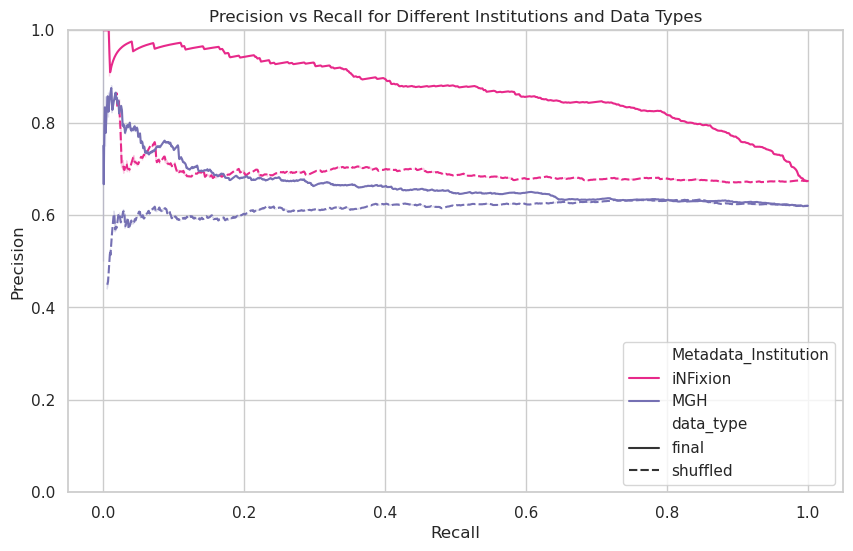

In [8]:
# Set the style of the plot
sns.set_theme(style="whitegrid")

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Define a color palette based on Set2 (you can adjust n_colors to match your needs)
institution_palette = sns.color_palette("Dark2", n_colors=8)

# Create a mapping dictionary of institutions to specific colors from Set2
institution_color_map = {
    "MGH": institution_palette[2],
    "iNFixion": institution_palette[3],
}

# Plot the data
sns.lineplot(
    data=precision_recall_df,
    x="Recall",
    y="Precision",
    hue="Metadata_Institution",
    style="data_type",
    palette=institution_color_map,
    dashes=True,
)

# Set y-axis limits
plt.ylim(0, 1)

# Add labels and title
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision vs Recall for Different Institutions and Data Types")
plt.legend(loc="lower right", bbox_to_anchor=(1, 0))
plt.show()

## Generate accuracy scores per institution and data type (final or shuffled)

In [9]:
# Calculate accuracy per institution and data type (final or shuffled) without the HET cells
accuracy_per_group = (
    combined_df[combined_df["Metadata_genotype"] != "HET"]
    .groupby(["Metadata_Institution", "data_type"])
    .apply(lambda x: accuracy_score(x["true_genotype"], x["predicted_genotype"]))
    .reset_index(name="accuracy")
)

# Save accuracy data to parquet file with qc suffix if data is cleaned
if data_cleaned == "cleaned":
    accuracy_file = pathlib.Path(results_dir) / "plate6_accuracy_final_model_qc.parquet"
else:
    accuracy_file = pathlib.Path(results_dir) / "plate6_accuracy_final_model.parquet"

accuracy_per_group.to_parquet(accuracy_file)

accuracy_per_group

,Metadata_Institution,data_type,accuracy
0,MGH,final,0.520804
1,MGH,shuffled,0.498960
2,iNFixion,final,0.673764
3,iNFixion,shuffled,0.508929


## Generate bar plot (for pre-visualization)

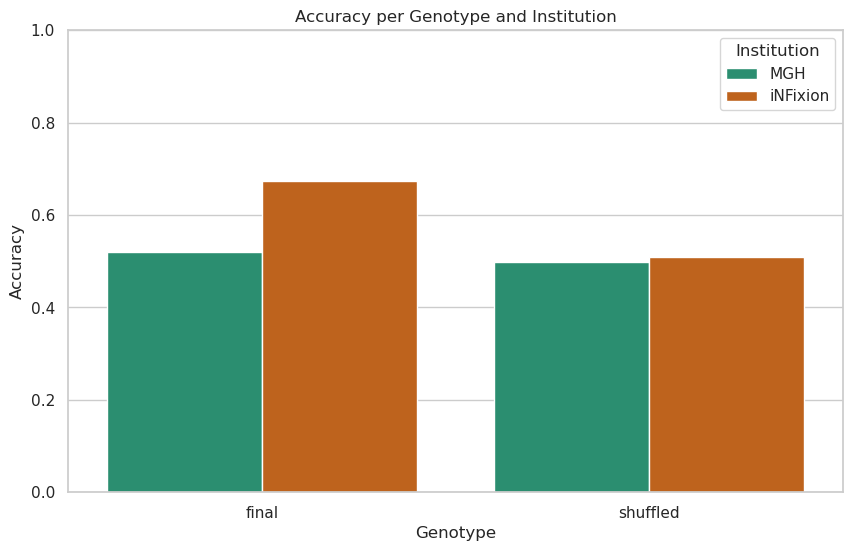

In [10]:
# Set the style of the plot
sns.set_theme(style="whitegrid")

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Create a bar plot
sns.barplot(
    data=accuracy_per_group,
    x="data_type",
    y="accuracy",
    hue="Metadata_Institution",
    palette="Dark2",
    errorbar=None,
)

# Set y-axis limits
plt.ylim(0, 1)

# Add labels and title
plt.xlabel("Genotype")
plt.ylabel("Accuracy")
plt.title("Accuracy per Genotype and Institution")
plt.legend(title="Institution")
plt.show()

## Look at how the accuracies break down per genotype

In [11]:
# Calculate accuracy per genotype, institution and data type (final or shuffled)
accuracy_per_group = (
    combined_df[combined_df["Metadata_genotype"] != "HET"]
    .groupby(["Metadata_genotype", "Metadata_Institution", "data_type"])
    .apply(lambda x: accuracy_score(x["true_genotype"], x["predicted_genotype"]))
    .reset_index(name="accuracy")
)

accuracy_per_group

,Metadata_genotype,Metadata_Institution,data_type,accuracy
0,Null,MGH,final,0.566606
1,Null,MGH,shuffled,0.502737
2,Null,iNFixion,final,0.774737
3,Null,iNFixion,shuffled,0.530526
4,WT,MGH,final,0.492729
5,WT,MGH,shuffled,0.496644
6,WT,iNFixion,final,0.624873
7,WT,iNFixion,shuffled,0.498471
